In [1]:
import re
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from helpers import Paper

## Authors and Titles

In [2]:
# Load the papers from the processing stage

with open('papers.pkl', 'rb') as f:
    papers: list[Paper] = pickle.load(f)

In [3]:
# Load the provided data regarding authors and titles

given_sample_df = pd.read_csv('ml-engineer/ICDAR 2024 paper list.csv', sep=',')

given_sample_df.head()

,ID,Authors,Title,Corresponding author 1,Corresponding author's Email
0,4,"Marco Peer, Florian Kleber and Robert Sablatnig",SAGHOG: Self-Supervised Autoencoder for Genera...,Marco Peer,mpeer@cvl.tuwien.ac.at
1,7,"Fabio Quattrini, Vittorio Pippi, Silvia Cascia...",Binarizing Documents by Leveraging both Space ...,Fabio Quattrini,fabio.quattrini@unimore.it
2,13,Solène Tarride and Christopher Kermorvant,Revisiting N-Gram Models: Their Impact in Mode...,Solène Tarride,starride@teklia.com
3,16,"Mayire Ibrayim, Mengmeng Chen, Askar Hamdulla,...",A Real-Time Scene Uyghur Text Detection Networ...,Mayire Ibrayim,mydear1949@163.com
4,18,"Laura Jamieson, Carlos Francisco Moreno-García...",A Multiclass Imbalanced Dataset Classification...,Carlos Fransisco Moreno-Garcia,c.moreno-garcia@rgu.ac.uk


In [4]:
# Check if the authors and titles match the given samples

given_sample_match_rows = []

for paper in papers:

    # extract ID from the filename
    id = re.findall(r'[0-9]{4}.pdf$|C[0-9]{2}.pdf', paper.filename)[0]
    id = re.sub(r'.pdf$', '', id)
    id = re.sub(r'^0*', '', id)

    # find the row in the given sample
    given_sample_row = given_sample_df[given_sample_df['ID'] == id]

    equal_authors = paper.authors == given_sample_row['Authors'].values[0]
    equal_titles = paper.title == given_sample_row['Title'].values[0]
    equal_corresponding = given_sample_row['Corresponding author 1'].values[0] in paper.authors

    given_sample_match_rows.append({'id': id, 'titles': equal_titles, 'authors': equal_authors, 'corresponding': equal_corresponding})

given_sample_match_df = pd.DataFrame(given_sample_match_rows).reset_index(drop=True)

given_sample_match_df.head()

,id,titles,authors,corresponding
0,4,True,True,True
1,7,True,True,True
2,13,True,False,False
3,16,True,True,True
4,18,False,False,False


In [5]:
# total number of papers
num_papers = len(papers)
num_rows = len(given_sample_match_df)
assert num_papers == num_rows

# number of papers with titles correctly extracted
num_true_titles = given_sample_match_df['titles'].sum()

# number of papers with authors correctly extracted
num_true_authors = given_sample_match_df['authors'].sum()

# number of papers with corresponding authors in the extracted authors
num_true_corresponding = given_sample_match_df['corresponding'].sum()

print(f'Number of papers: {num_papers}')
print(f'Number of papers with titles correctly extracted: {num_true_titles}')
print(f'Number of papers with authors correctly extracted: {num_true_authors}')
print(f'Number of papers with corresponding authors in the extracted authors: {num_true_corresponding}')

Number of papers: 148
Number of papers with titles correctly extracted: 108
Number of papers with authors correctly extracted: 61
Number of papers with corresponding authors in the extracted authors: 112


## Categories

#### Sample Ground Truth

In [6]:
# Load small sample of papers labeled manually for evaluation

sample_ground_truth_df = pd.read_csv('sample-ground-truth.csv', sep=';')

print(len(sample_ground_truth_df))

17


#### Sentence Similarity

In [7]:
similarity_preds_df = pd.read_csv('similarity-preds.csv', sep=';')

similarity_preds_df['category'].value_counts()

category
Optical Character Recognition    75
Key Information Extraction       22
Document Layout Understanding    19
Datasets                         12
Classification                   10
Tables                           10
Name: count, dtype: int64

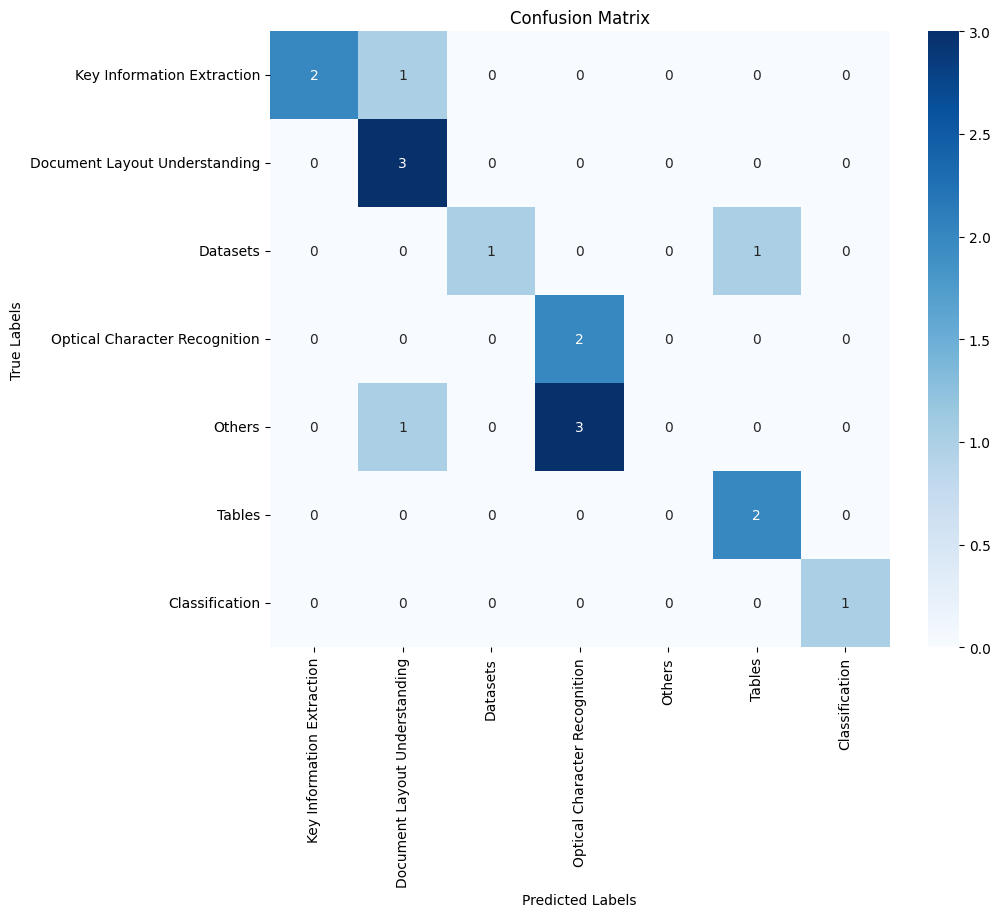

In [8]:
predicted_categories = similarity_preds_df[similarity_preds_df['filename'].isin(sample_ground_truth_df['filename'])]['category']

true_categories = sample_ground_truth_df['category']

# Compute confusion matrix
conf_matrix = confusion_matrix(true_categories, predicted_categories, labels=true_categories.unique())

# Convert to DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix, index=true_categories.unique(), columns=true_categories.unique())

# Plot confusion matrix with annotations
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('similarity-confusion-matrix.png', bbox_inches='tight')

#### Sentence Similarity with Extended Categories

In [9]:
similarity_preds_ext_df = pd.read_csv('similarity-preds-ext.csv', sep=';')

similarity_preds_ext_df['category'].value_counts()

category
Optical Character Recognition    70
Others                           21
Key Information Extraction       18
Document Layout Understanding    18
Tables                           11
Classification                    7
Datasets                          3
Name: count, dtype: int64

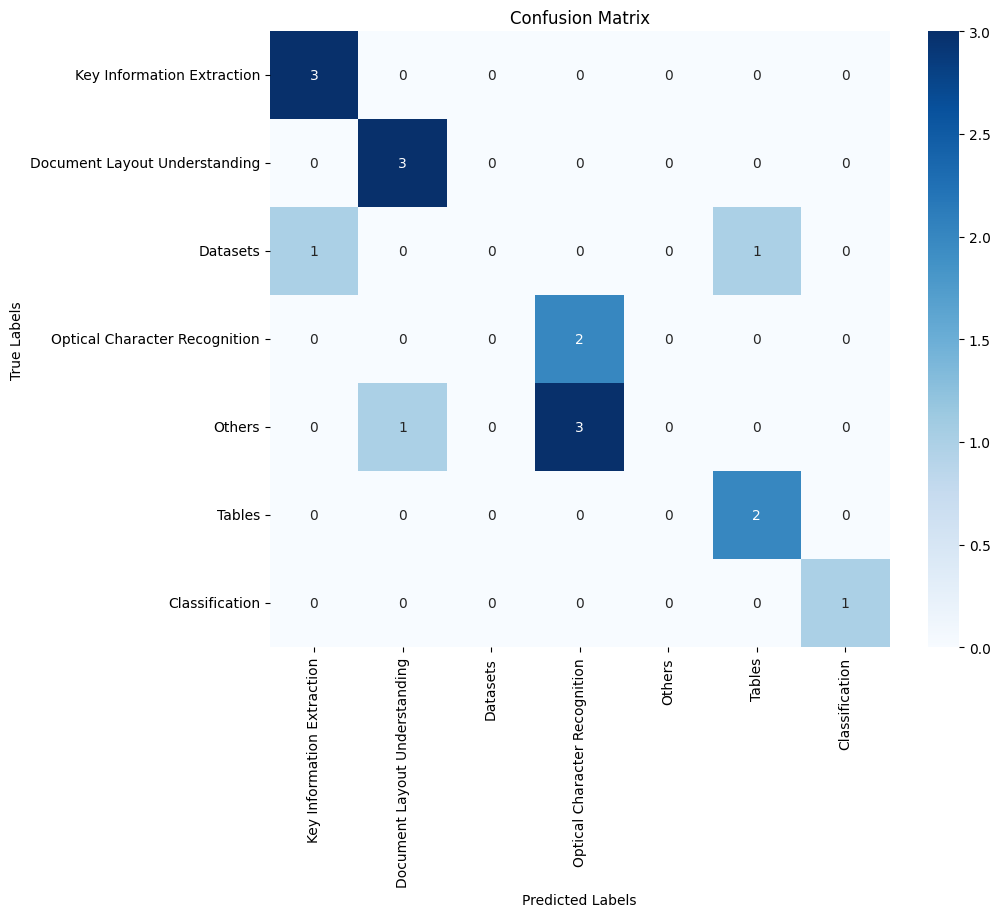

In [10]:
predicted_categories = similarity_preds_ext_df[similarity_preds_ext_df['filename'].isin(sample_ground_truth_df['filename'])]['category']

true_categories = sample_ground_truth_df['category']

# Compute confusion matrix
conf_matrix = confusion_matrix(true_categories, predicted_categories, labels=true_categories.unique())

# Convert to DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix, index=true_categories.unique(), columns=true_categories.unique())

# Plot confusion matrix with annotations
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('similarity-confusion-matrix-ext.png', bbox_inches='tight')

#### Text Generation with Causal Language Modeling

In [11]:
generation_clm_df = pd.read_csv('generation-clm.csv', sep=';')

generation_clm_df['category'].value_counts()

category
Tables            147
Classification      1
Name: count, dtype: int64

#### Text Generation with Instruction-tuned Language Modeling

In [12]:
generation_itlm_df = pd.read_csv('generation-itlm.csv', sep=';')

generation_itlm_df['category'].value_counts()

category
Document Layout Understanding    116
Classification                    32
Name: count, dtype: int64